## Wrangle the stock data

In [18]:
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
# Make plots bigger
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
API_KEY = "KRN14ZLFIAEX3YGN"

In [4]:
#download the dataset
ts = TimeSeries(key=API_KEY, output_format='pandas')
#DJI = https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

#daily - get daily info up to 20a
allData, meta_data = ts.get_daily(symbol='DJI', outputsize='full')

In [5]:
# We can describe it
print(allData.describe())
print(meta_data)

            1. open      2. high        3. low      4. close     5. volume
count   4720.000000   4720.00000   4720.000000   4720.000000  4.720000e+03
mean   13244.359442  13321.49584  13164.802921  13247.107333  2.135933e+08
std     4301.314051   4304.30150   4299.263293   4302.667974  9.798946e+07
min     6547.009800   6709.60990   6469.950200   6547.049800  8.410000e+06
25%    10368.024650  10429.10500  10291.844725  10368.275375  1.386275e+08
50%    11564.475100  11636.38525  11500.779750  11570.955100  2.090350e+08
75%    16057.397475  16172.23000  15947.947775  16059.954575  2.668150e+08
max    26833.470700  26951.81050  26789.080100  26828.390600  8.239400e+08
{'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'DJI', '3. Last Refreshed': '2018-10-04', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


In [76]:
#data = allData[:100] # first n rows
data = allData
print (data.describe())
print(data.index)

            1. open      2. high        3. low      4. close     5. volume
count   4720.000000   4720.00000   4720.000000   4720.000000  4.720000e+03
mean   13244.359442  13321.49584  13164.802921  13247.107333  2.135933e+08
std     4301.314051   4304.30150   4299.263293   4302.667974  9.798946e+07
min     6547.009800   6709.60990   6469.950200   6547.049800  8.410000e+06
25%    10368.024650  10429.10500  10291.844725  10368.275375  1.386275e+08
50%    11564.475100  11636.38525  11500.779750  11570.955100  2.090350e+08
75%    16057.397475  16172.23000  15947.947775  16059.954575  2.668150e+08
max    26833.470700  26951.81050  26789.080100  26828.390600  8.239400e+08
Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2018-09-21', '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
       '2018-09-28', '2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04'],
     

In [77]:
print(data.shape)

sample_size = data.shape[0]-1
endpoints = data[1:]
startpoints = data[:sample_size]

print (startpoints.index)
print (endpoints.index)

#save the startpoint index to be used as the date. This way yesterday's bin will hold value
#of change between yesterdays closing and todays closing, so yesterdays tweets get the value impact of today's
#stock market value development
indexes = startpoints.index

#let's reset the indexes
startpoints = startpoints.reset_index()
endpoints = endpoints.reset_index()
print (startpoints.index)
print (endpoints.index)


(4720, 5)
Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2018-09-20', '2018-09-21', '2018-09-24', '2018-09-25', '2018-09-26',
       '2018-09-27', '2018-09-28', '2018-10-01', '2018-10-02', '2018-10-03'],
      dtype='object', name='date', length=4719)
Index(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-10',
       '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14', '2000-01-18',
       ...
       '2018-09-21', '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
       '2018-09-28', '2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04'],
      dtype='object', name='date', length=4719)
RangeIndex(start=0, stop=4719, step=1)
RangeIndex(start=0, stop=4719, step=1)


In [78]:
daily_change = endpoints["4. close"] - startpoints["4. close"]
print(daily_change.describe())

count    4719.000000
mean        3.254698
std       132.344296
min     -1175.210900
25%       -57.754900
50%         6.060600
75%        69.030300
max       936.420000
Name: 4. close, dtype: float64


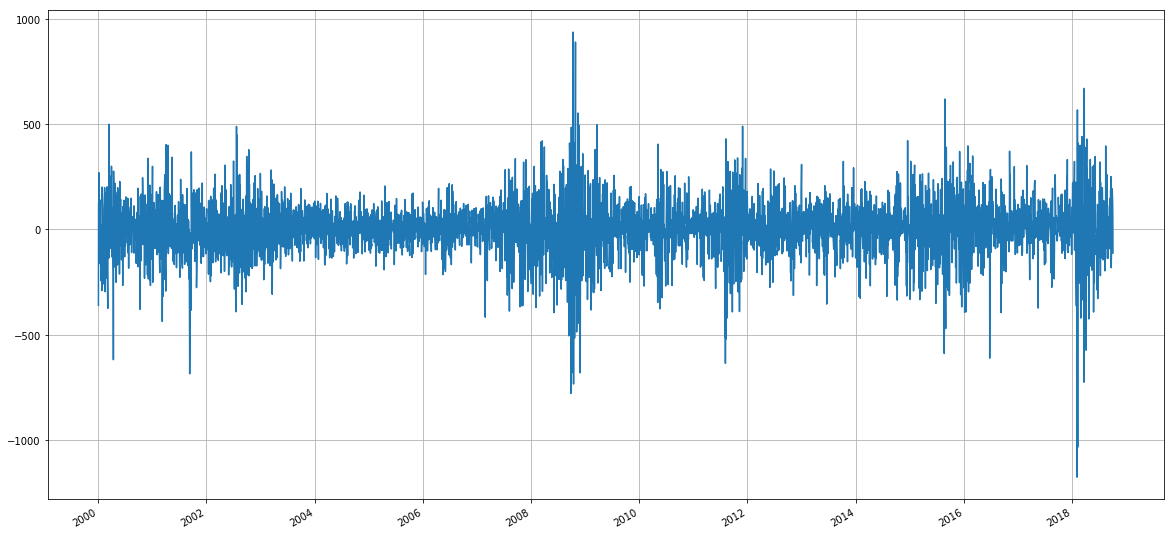

In [79]:
# change the dates in indexes to pandas Timestamps
indexes = pd.to_datetime(indexes)

#use the saved value for date-data
dates = indexes

fig, ax = plt.subplots()
ax.plot(dates, daily_change)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.grid()
plt.show()

In [101]:
#write data as json
import json

df = pd.DataFrame(daily_change)
df.index = dates

print(df.describe())

name = "DJI-20years-daily-change.json"
with open(name, 'w') as file:
    file.write(df.to_json())

          4. close
count  4719.000000
mean      3.254698
std     132.344296
min   -1175.210900
25%     -57.754900
50%       6.060600
75%      69.030300
max     936.420000


In [99]:
#read data as json
name = "DJI-20years-daily-change.json"
with open(name, "r") as file:
    read_frame = pd.read_json(file)
print(read_frame.describe())

          4. close
count  4719.000000
mean      3.254698
std     132.344296
min   -1175.210900
25%     -57.754900
50%       6.060600
75%      69.030300
max     936.420000


In [107]:
a = 365
x = len(daily_change)

#data of the past year
data = daily_change[x-a:]
dates_year = indexes[x-a:]

print("data:",data.describe())
print("\ndates:",dates_year[:20])

data: count     365.000000
mean       15.672084
std       183.908043
min     -1175.210900
25%       -45.160200
50%        25.609400
75%        95.019600
max       669.400400
Name: 4. close, dtype: float64

dates: DatetimeIndex(['2017-04-25', '2017-04-26', '2017-04-27', '2017-04-28',
               '2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-22'],
              dtype='datetime64[ns]', name='date', freq=None)


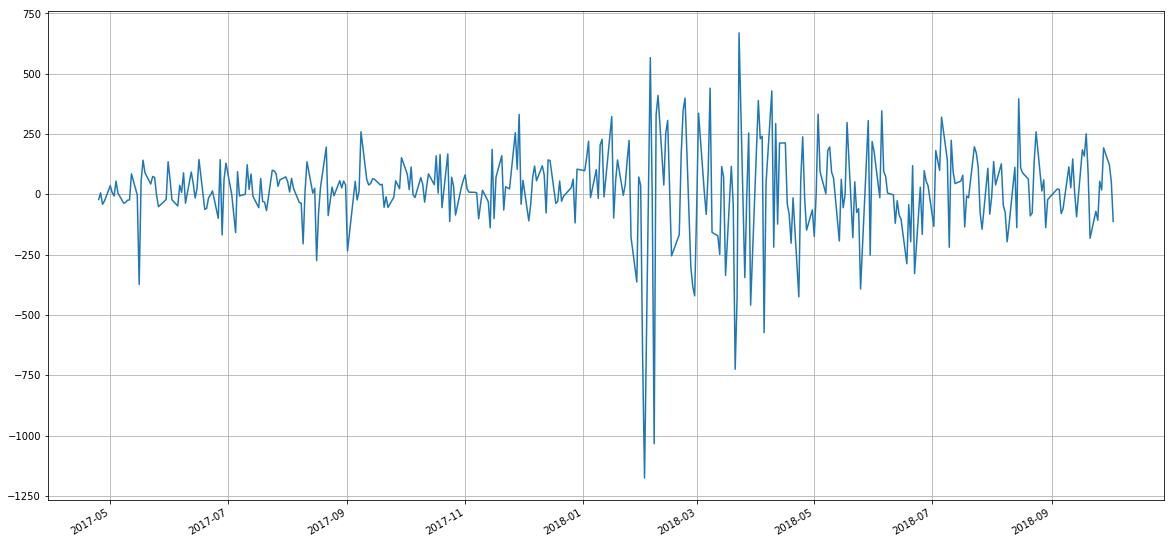

In [108]:
fig, ax = plt.subplots()
ax.plot(dates_year, data)

fig.autofmt_xdate()

plt.grid()
plt.show()

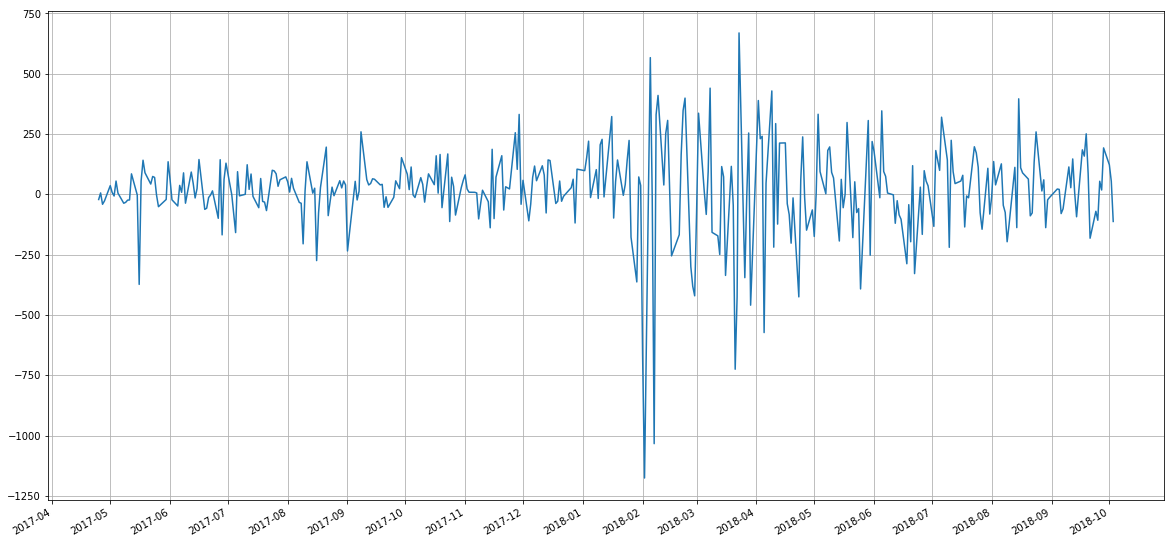

In [109]:
#example of using different locator
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(dates_year, data)

#yearLoc = mdates.YearLocator()
#ax.xaxis.set_major_locator(yearLoc)
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

monthLoc = mdates.MonthLocator()
ax.xaxis.set_major_locator(monthLoc)
#ax.xaxis.set_minor_locator(monthLoc)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))

fig.autofmt_xdate()

plt.grid()
plt.show()

In [118]:
#write the one year data to json file
df = pd.DataFrame(data)
df.index = dates_year
print(df.head())

latest_date = df.index[-1].strftime('%Y-%m-%d')
name = "DJI-last-year-stock-until-" + latest_date + ".json"

with open(name, "w") as file:
    file.write(df.to_json())

            4. close
date                
2017-04-25  -21.0293
2017-04-26    6.2403
2017-04-27  -40.8203
2017-04-28  -27.0489
2017-05-01   36.4297


In [131]:
#read one year data

import os

df = None
for filename in os.listdir():
    if os.path.isfile(filename):
        with open(filename, "r") as file:
            if "DJI-last-year-stock-until-" in file.name:
                df = pd.read_json(file)
                break
                
if df is None: print("file not found!")
else: print(df.head())

            4. close
2017-04-25  -21.0293
2017-04-26    6.2403
2017-04-27  -40.8203
2017-04-28  -27.0489
2017-05-01   36.4297
